# Lab 3 - Linear and Logistic Regression
Dominik Gaweł

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dg7s/Machine-Learning/blob/main/hw/Optimizing_the_Classification_Threshold_in_Logistic_Regression.ipynb)
-------------------------------

# **Homework Assignment: Optimizing the Classification Threshold in Logistic Regression**

-------------------------------

In this assignment, you will explore the concept of **classification thresholds** in **Logistic Regression** and investigate whether the commonly used threshold of **0.5** is always the optimal choice. To complete this assignment, you will need to conduct **additional reading** on **ROC curves** and the **AUC metric**, beyond the materials covered in class.

This exercise focuses on the **importance of threshold selection** and how it impacts model performance based on different evaluation criteria.



## **The Objective**

**Is a 0.5 threshold always the best choice in Logistic Regression?**

- Analyze if the standard threshold of **0.5** always yields the most desirable results in various scenarios.
- Investigate alternative thresholds and how they can improve model performance depending on the problem context.



## **Helper Questions**

1. **Would a different threshold yield better results?**  
   - How does shifting the threshold affect the **trade-off between sensitivity and specificity**?

2. **How do you define "better" results?**  
   - Is **higher specificity** more valuable than **higher sensitivity** in certain contexts? Or maybe the other way around?
   - Does the **best threshold** depend on the task? (discuss cases like *disease detection* vs. *spam filtering*)

3. **How does a ROC curve help in this process?**  
   - Learn how to use a **ROC curve** to visualize the trade-off between **True Positive Rate (Sensitivity)** and **False Positive Rate (1 - Specificity)**.

4. **How do you select the optimal threshold using the ROC curve?**  
   - Discuss strategies to select a threshold depending on the specific task at hand and the acceptable **trade-off between sensitivity and specificity**.

5. **What is the AUC metric and how is it useful?**  
   - Define **AUC (Area Under the Curve)** and discuss its role in evaluating the overall performance of a classifier.



## **Tasks & Deliverables**

1. **Colab Notebook**
   - Select a suitable classification 2-class dataset.
   - Divide the dataset into three parts: **train**, **validation**, and **test**.
   - Train the **Logistic Regression** model on the **training** set.
   - Use the **validation** set to:
     - Plot the **ROC curve**.
     - Calculate the **AUC**.
     - Determine the **optimal threshold** using the ROC curve for your dataset.
   - Apply the selected threshold to the **test** set to evaluate final model performance using metrics like:
     - **Accuracy**
     - **Precision & Recall**
     - **F1-Score**
     - **Specificity & Sensitivity**

2. **Answer the Questions:**
   - Use markdown cells to provide explanations.
   - Answer all helper questions with supporting evidence from your plots and results.

3. **Visualizations:**
   - **ROC curve** based on the **validation** set with threshold points marked.
   - Highlight the **optimal threshold** on the ROC curve.

4. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# For simplicity we stick to the Dataset given by 'sklearn.datasets'
data = load_breast_cancer()
X, y = data.data, data.target

df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(df.head(5).T)

# Distribution of the target variable
target_counts = df['target'].value_counts()

cancer_count = target_counts.get(1, 0)  # 1 corresponds to cancer
healthy_count = target_counts.get(0, 0)  # 0 corresponds to healthy

print(f"\nCancer: {cancer_count}, Healthy: {healthy_count}")

                                   0            1            2           3            4
mean radius                17.990000    20.570000    19.690000   11.420000    20.290000
mean texture               10.380000    17.770000    21.250000   20.380000    14.340000
mean perimeter            122.800000   132.900000   130.000000   77.580000   135.100000
mean area                1001.000000  1326.000000  1203.000000  386.100000  1297.000000
mean smoothness             0.118400     0.084740     0.109600    0.142500     0.100300
mean compactness            0.277600     0.078640     0.159900    0.283900     0.132800
mean concavity              0.300100     0.086900     0.197400    0.241400     0.198000
mean concave points         0.147100     0.070170     0.127900    0.105200     0.104300
mean symmetry               0.241900     0.181200     0.206900    0.259700     0.180900
mean fractal dimension      0.078710     0.056670     0.059990    0.097440     0.058830
radius error                1.09

In [ ]:
# Split dataset: 60 : 20 : 20
X_train, X_tests, y_train, y_tests = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tests, y_tests, test_size=0.5, random_state=42, stratify=y_tests)

# Fit Logistic Regression
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

y_val_probs = logistic_model.predict_proba(X_val)[:, 1]  # Probabilities for class 1
y_val_preds = logistic_model.predict(X_val)  # Predicted classes (0 or 1)

1. Different thresholds yield different results, but it's hard to say which result is “better” without specifying a performance metric. Two fundamental rates we focus on are the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**. These are related to **sensitivity** and **specificity** as follows:

    - **TPR = Sensitivity**
    - **FPR = 1 - Specificity**

    As the threshold increases, both **TPR** and **FPR** tend to decrease. We will discuss this trade-off further in the following points.


2. In general, it is not clear whether higher **sensitivity** **(TPR)** or higher **specificity** is preferable—it depends on the context. For instance, when detecting cancer:

    - when performing preliminary screening for cancer detection, we might prioritize **sensitivity** by aiming for a high **TPR**, since it is crucial to detect as many potential cases as possible and avoid missing any individuals who may be sick.
    - However, in confirmatory testing, we tend to focus on **specificity** by aiming for a low **FPR**, thereby ensuring that healthy patients are not subjected to unnecessary and potentially harmful treatments.

    For email spam filtering, a similar trade-off exists.
    - If the priority is to prevent important emails from being misclassified as spam, we might lean towards a threshold that emphasizes higher **specificity**, even if it means allowing some spam messages to slip through.
    - if the goal is to block as much spam as possible, we would prioritize **sensitivity**, accepting that this might result in a few legitimate emails being mistakenly flagged as spam.

    Yes, the best treshold depend on the task.

3. We can use `roc_curve()` from `scikit-learn` to compute the **TPR**, **FPR**, and the corresponding thresholds based on our model’s predicted probabilities. The **ROC curve** visually shows how **TPR** and **FPR** change across different thresholds.

4. As discussed in point `2`, there is always a trade-off between **sensitivity** and **specificity**. Here, we will use **Youden's J statistic** which is
    $$
    J = \text{sensitivity} + (\text{specifity} - 1).
    $$
    This is the standard metric which balances the reward for high **TPR** and penalizes high **FPR**. Alternatively, one may choose to maximize an arbitrary function of **TPR** and **FPR**, depending on the specific problem requirements.

5. **AUC** - area under the **ROC curve**. It represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative. According to **AUC** we can compare two different models. The model with greater area under the curve is generally the better one, as long as the dataset is roughtly balanced. We will use `roc_auc_score()` from `scikit-learn`. The disscusion about the evaluation on the `test set` will be below the results.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
auc_score = roc_auc_score(y_val, y_val_probs)
print("Validation AUC:", auc_score)

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

Validation AUC: 0.9947089947089947
Optimal threshold: 0.8019222419752329


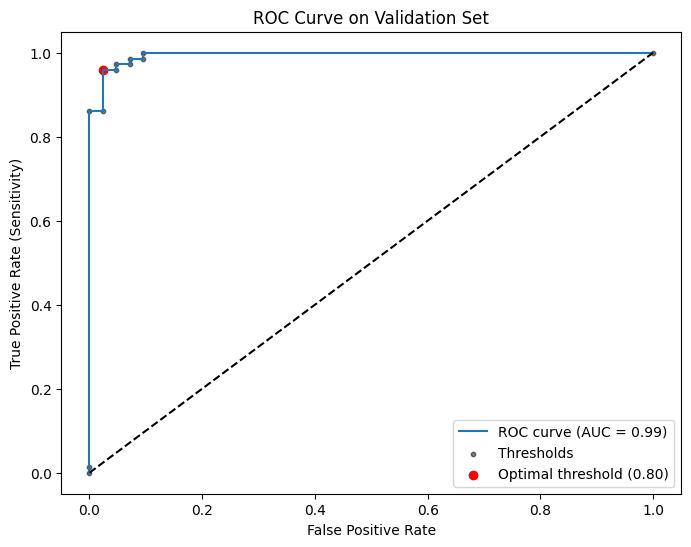

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')

plt.scatter(fpr, tpr, color='black', s=10, alpha=0.5, label='Thresholds')

plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold ({optimal_threshold:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.show()

In [ ]:
# 4. Evaluation on Test Set
y_test_probs = logistic_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)  # Sensitivity
f1 = f1_score(y_test, y_test_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Sensitivity (Recall): {recall:.2f}")
print(f"Test Specificity: {specificity:.2f}")
print(f"Test F1-Score: {f1:.2f}")

Test Accuracy: 0.96
Test Precision: 0.99
Test Sensitivity (Recall): 0.96
Test Specificity: 0.98
Test F1-Score: 0.97


The model achieved a **Test Accuracy** of **0.96**, the **Test Precision** is **0.99**, meaning that when the model predicts a positive, it is correct 99% of the time. The Test **Sensitivity** is **0.96**, reflecting that the model successfully identifies 96% of all actual positives. In addition, the **Test Specificity** is **0.98**, showing that 98% of actual negatives are correctly classified. Finally, the **Test F1-Score** of **0.97**, as a the harmonic mean of precision and **TPR** confirms a strong balance between those two.

Overall, these model performs well.
